## CS6650 Homework 1 (Holi 2023 Semester)

**Submission by:** Ashwin A Nayar (NA19B001)

#### Smartphone based Photoplethysmography (PPG)

The task is to develop a PPG system using a smartphone device to capture blood flow related imagery data and post-process such data to estimate the pulse or heart beat rate of the subject. You need to implement various features pertaining to the above task in this notebook. Create a directory, <b><your_roll>\_CS6650H23</b>. Place this notebook in that directory.

#### A. Warmup - Data Collection [10 points]

Use your smartphone’s camera to capture the blood-flow video. Turn on the flash while recording and turn it off once done. Capture the video using the maximum frame rate that is available in your phone (e.g.60 fps or 30 fps). The same holds for image resolution. The captured videos are saved on the device’s SD card. Collect 3 such videos (each exactly 10 seconds long, if longer just limit to N frames while processing, where N = 10\*frames_per_second) under the following conditions. Make sure that all video capture configurations are kept the same across the cases (resolution, fps).

- resting on bed (1.mp4)
- after a moderate walk (2.mp4), and
- after a vigorous exercise (3.mp4).

Copy these videos locally to your project folder in a subdirectory "ppgvideos" - name them (1/2/3).mp4. Don’t move your finger/hand randomly or press too hard against the camera or flash while recording, little randomness is okay. Write a script to read the three videos and store the frames (2D vector of (R G B) values).


In [1]:
import cv2
import numpy as np
import scipy.signal as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

sns.set_theme()
cmap = sns.color_palette()

# Duration of the video is clipped to this many seconds for processing
MAX_VIDEO_DURATION_SECS = 10

# We are only interested in detecting heartbeat within this range. Any frequencies outside this range are attenuated during preprocessing
HEARTBEAT_DETECT_MIN_BPM = 45
HEARTBEAT_DETECT_MAX_BPM = 240

# Relative paths to video files for processing
videoPaths = ["ppgvideos/1.mp4", "ppgvideos/2.mp4", "ppgvideos/3.mp4"]
# Map from video ID to its raw frame data
videoFrames = defaultdict(list)
# Map from video ID to video metadata such as fps, frame count etc for future processing
videoMeta = {}

for index, videoPath in enumerate(videoPaths):
    videoID = index + 1
    cap = cv2.VideoCapture(videoPath)

    # some sample constants in openCV, check out for more
    fps = cap.get(cv2.CAP_PROP_FPS)
    cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    f_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    f_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    readFramesCnt = 0
    while cap.isOpened() and readFramesCnt < MAX_VIDEO_DURATION_SECS * fps:
        ret, frame = cap.read()
        if ret:
            videoFrames[videoID].append(frame)
            readFramesCnt += 1
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

    videoMeta[videoID] = {
        "FPS": fps,
        "FrameCount": readFramesCnt,
        "FrameWidth": f_w,
        "FrameHeight": f_h,
    }

    print(f"{videoPath}, Frames read: {readFramesCnt}/{cnt}, FPS: {fps:0.2f}")


ppgvideos/1.mp4, Frames read: 304/689, FPS: 30.33
ppgvideos/2.mp4, Frames read: 304/656, FPS: 30.30
ppgvideos/3.mp4, Frames read: 300/752, FPS: 30.00


#### B. Sensing Metric [5 points]

Design your sensing metric. Note that each frame is a 2D vector of size [AxB], containing A.B pixels, where a pixel at location [i,j] is denoted by the 3-tuple [B, G, R] where B, G, and R are bytes (8 bits, range 0 - 255) representing intensity of each color - Blue, Green and Red. The frame intensity metric is an aggregate statistical measure on the pixel values. (you can even consider R, G and B streams separately or consider greyscale frames). Best to have a normalized value between zero and one. [5 points]


**Sol.** Data is preprocessed in multiple stages as follows;

    1. For each channel, the values are spatially averaged over the frame to improve SNR. This results in a time series signal per channel.

    2. Detrending is applied to each channel signal to remove stationary/linear components.

    3. Using a simple 1x3 kernel, smoothing is done per channel (Effectively, this is a weighted moving average).

    4. PCA was applied to map the channel signals to eigenvectors. The projection along the first eigenvector is the component with the highest variance and thus is chosen as the PPG signal.

    5. A bandpass filter is used to attenuate frequencies outside the desired detection range.

    6. Finally, signal is normalized to [0, 1] range


In [2]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    """Butterworth bandpass filter to filter out frequencies outside the range [`lowcut`, `highcut`] from `data`"""

    def butter_bandpass_ss(_lowcut, _highcut, _fs, _order=3):
        """Genereates state space model for butterworth filter."""
        return sp.butter(_order, [_lowcut, _highcut], fs=_fs, btype="band")

    b, a = butter_bandpass_ss(lowcut, highcut, fs, order)
    y = sp.lfilter(b, a, data)
    return y


# Maps videoID to the final sensing metric timeseries
sensingMetricTS = {}

for videoID, frames in videoFrames.items():
    frameData = []

    for frame in frames:
        # Spatial average over entire frame, per channel
        frameData.append(frame.mean(axis=0).mean(axis=0))

    # shape: readFramesCount x 3
    frameData = np.array(frameData)

    # Detrend to remove stationary/linear components from signal
    # Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html#scipy.signal.detrend
    frameData = sp.detrend(frameData, axis=0)

    for channel in range(frameData.shape[1]):
        # Kernel smoothing using a 1x3 [0.25, 0.5, 0.25] kernel for each channel
        frameData[:, channel] = np.convolve(
            frameData[:, channel], [0.25, 0.5, 0.25], "same"
        )

        # Standardize data for PCA (ideally we require mean = 0 and std. deviation = 1)
        frameData[:, channel] -= frameData[:, channel].mean()
        frameData[:, channel] /= frameData[:, channel].std()

    # Compute SVD of data matrix and project data along highest variance component to obtain heartbeat signal
    _, _, V = np.linalg.svd(frameData)
    sensingMetric = np.dot(frameData, V[0, :])

    # Filter out any frequency components above or below our desired detection range
    # 60 BPM <=> 1 Hz
    cutoff_low = HEARTBEAT_DETECT_MIN_BPM / 60
    cutoff_high = HEARTBEAT_DETECT_MAX_BPM / 60
    sensingMetric = butter_bandpass_filter(
        sensingMetric, cutoff_low, cutoff_high, fs=videoMeta[videoID]["FPS"]
    )

    # Normalize final signal to [0, 1]
    mn = sensingMetric.min()
    mx = sensingMetric.max()
    sensingMetric = (sensingMetric - mn) / (mx - mn)

    # Save pre-processed data
    sensingMetricTS[videoID] = sensingMetric


#### C. Temporal Variation of Intensity Value [10 points]

Plot your frame intensity metric vs. time for a random 5-second chunk of the three videos. The X-axis should be common for all three subplots (stacked vertically) with separate Y-axes based on your intensity metric. Appreciate the fact that vigorous exercise leads to rapid intensity variations compared to while resting. What is the BPM value for the three cases (manually counting is okay)?


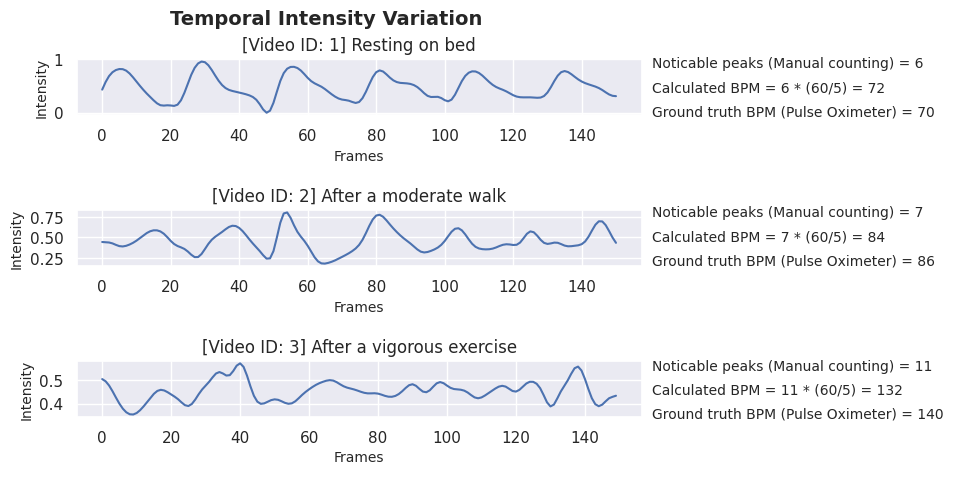

In [3]:
plt.rcParams["figure.constrained_layout.use"] = True

CHUNK_DURATION_SECS = 5

# We will take last n-frames chunk (n computed from the duration)

plt.subplot(3, 1, 1)
vid = 1
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
plt.plot(sensingMetricTS[vid][-chunk_n_frames:])
plt.title(f"[Video ID: {vid}] Resting on bed")
plt.xlabel("Frames\n", fontsize="small")
plt.ylabel("Intensity", fontsize="small")

plt.subplot(3, 1, 2)
vid = 2
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
plt.plot(sensingMetricTS[vid][-chunk_n_frames:])
plt.title(f"[Video ID: {vid}] After a moderate walk")
plt.xlabel("Frames\n", fontsize="small")
plt.ylabel("Intensity", fontsize="small")

plt.subplot(3, 1, 3)
vid = 3
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
plt.plot(sensingMetricTS[vid][-chunk_n_frames:])
plt.title(f"[Video ID: {vid}] After a vigorous exercise")
plt.xlabel("Frames\n", fontsize="small")
plt.ylabel("Intensity", fontsize="small")

plt.rcParams["font.size"] = 10

plt.figtext(1.01, 0.87, "Noticable peaks (Manual counting) = 6")
plt.figtext(1.01, 0.87 - 0.05, "Calculated BPM = 6 * (60/5) = 72")
plt.figtext(1.01, 0.87 - 2 * 0.05, "Ground truth BPM (Pulse Oximeter) = 70")

plt.figtext(1.01, 0.56, "Noticable peaks (Manual counting) = 7")
plt.figtext(1.01, 0.56 - 0.05, "Calculated BPM = 7 * (60/5) = 84")
plt.figtext(1.01, 0.56 - 2 * 0.05, "Ground truth BPM (Pulse Oximeter) = 86")

plt.figtext(1.01, 0.24, "Noticable peaks (Manual counting) = 11")
plt.figtext(1.01, 0.24 - 0.05, "Calculated BPM = 11 * (60/5) = 132")
plt.figtext(1.01, 0.24 - 2 * 0.05, "Ground truth BPM (Pulse Oximeter) = 140")

plt.suptitle("Temporal Intensity Variation", fontsize=14, fontweight="bold")
plt.show()


#### D. Likelihood Distributions [20 marks]

In the 5-second chunks taken above, choose 20 frames where your sensing metric is close to the local maximum (Case1), and 20 frames where it is close to the local minimum (Case2). Plot the histograms on "R", "G" and "B" values for each pixel in the 20 frames for the two cases 1 and 2. For each video there will be 3 figures, each for "R", "G" and "B". Which one produces the most separable distributions?


**Sol.**
For all three datasets and almost all the three channels, there is a significant if not complete overlap between the distributions. This is because for one single frame there is quite significant variation in pixel values in all 3 channels. Thus the information encoded in a single pixel is not enough to capture and classify it as a positive/negative event. However, after further analysis, it was found that taking spatial average over an entire frame and plotting histogram instead of considering all the pixels significantly improved the separability of distributions and this is because spatial averaging improves SNR in this particular use case, since
we can intuitively imagine the average pixel intensity varying with the hearbeat signal proportionately, capturing the signal data with it.

When considering all the pixels, pixels close to the flashlight are more brighter than the ones farther away and this intensity variation within a frame itself
introduces variability in the distributions, significantly reducing the separability of distributions.


/home/ashwin/github.com/CS6650-Smart-Sensing-for-IoT/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


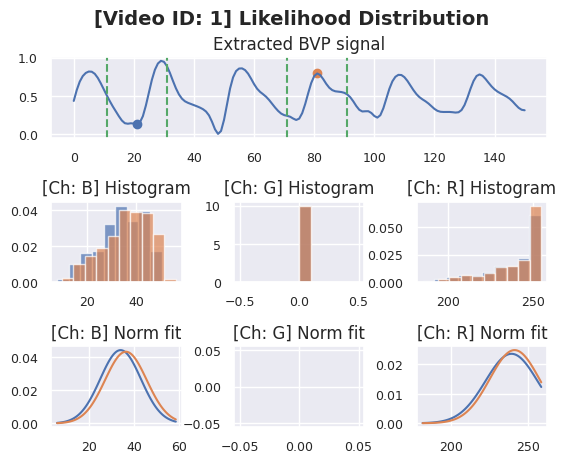

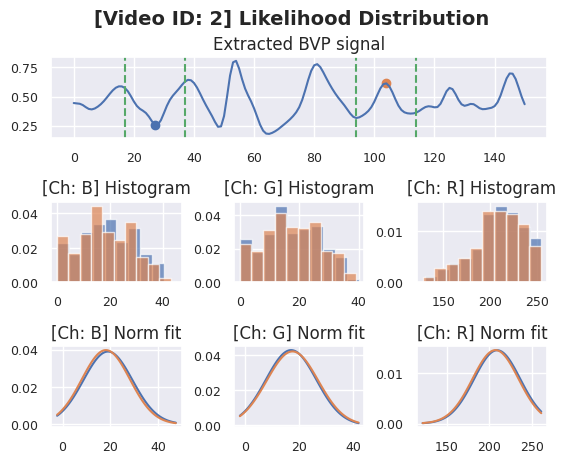

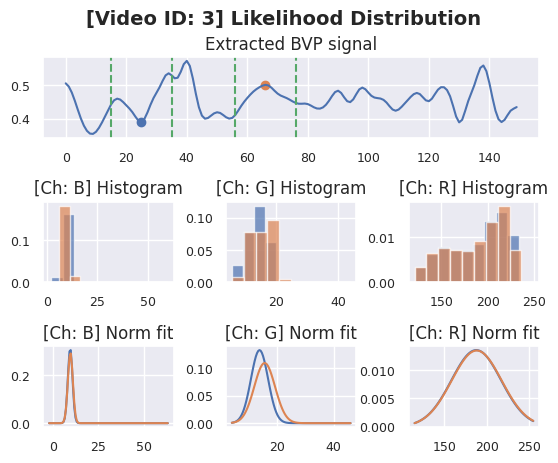

In [4]:
plt.rcParams["figure.constrained_layout.use"] = False
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9

# Size of neighbourhood
NHOOD_SIZE = 20

# Maps video ID to event data (maxima,minima) and corresponding statistical metrics
event_data = dict.fromkeys(sensingMetricTS.keys())

for videoID, sensingMetric in sensingMetricTS.items():
    event_data[videoID] = dict.fromkeys("BGR")

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.8, wspace=0.4)

    chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[videoID]["FPS"])
    data = sensingMetricTS[videoID][-chunk_n_frames:]
    # Manually choose an optimal minimum and maximum peak so that the window doesn't overlap with neighbouring maxima/minima
    idx_min_peak = sp.find_peaks(1 - data)[0][1]
    idx_max_peak = sp.find_peaks(data)[0][4]

    # Compute neighbourhood begin and end indices for maxima and minima
    maxp_nhood_begin = idx_max_peak - NHOOD_SIZE // 2
    maxp_nhood_end = maxp_nhood_begin + NHOOD_SIZE

    minp_nhood_begin = idx_min_peak - NHOOD_SIZE // 2
    minp_nhood_end = minp_nhood_begin + NHOOD_SIZE

    # Visualize the chosen neighbourhood and maxima/minima
    plt.subplot(3, 1, 1)
    plt.plot(data)
    plt.scatter(idx_min_peak, data[idx_min_peak], color=cmap[0])
    plt.scatter(idx_max_peak, data[idx_max_peak], color=cmap[1])
    plt.axvline(minp_nhood_begin, linestyle="--", color=cmap[2])
    plt.axvline(minp_nhood_end, linestyle="--", color=cmap[2])
    plt.axvline(maxp_nhood_begin, linestyle="--", color=cmap[2])
    plt.axvline(maxp_nhood_end, linestyle="--", color=cmap[2])
    plt.title("Extracted BVP signal")

    # The begin and end indices for maxima and minima neighbourhood is with respect to the chosen chunk
    # of frames. We calculate the offset and find the corresponding indices in the total frame data
    # for further computation
    offset = videoMeta[videoID]["FrameCount"] - chunk_n_frames

    # Shift all relevant indices by offset
    minp_nhood_begin += offset
    minp_nhood_end += offset
    idx_min_peak += offset

    maxp_nhood_begin += offset
    maxp_nhood_end += offset
    idx_max_peak += offset

    # Extract frame data corresponding to event neighbourhood
    # shape: (20 X height x width X 3)
    l_min_nhood = np.array(videoFrames[videoID][minp_nhood_begin:minp_nhood_end])
    l_max_nhood = np.array(videoFrames[videoID][maxp_nhood_begin:maxp_nhood_end])

    i_subplot = 4  # Subplot ID
    for ich, ch in enumerate("BGR"):
        mx_data = l_max_nhood[:, :, :, ich].flatten()
        mn_data = l_min_nhood[:, :, :, ich].flatten()

        # Visualize frequency distribution, the histograms are normalized along y axis for visual appeal
        plt.subplot(3, 3, i_subplot)
        plt.hist(mn_data, color=cmap[0], density=True, alpha=0.7)
        plt.hist(mx_data, color=cmap[1], density=True, alpha=0.7)
        plt.title(f"[Ch: {ch}] Histogram")

        # Fit normal distribution to data, compute mean and standard deviation
        mn_mu, mn_std = norm.fit(mn_data)
        mx_mu, mx_std = norm.fit(mx_data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)

        # Visualize fitted normal distribution
        plt.subplot(3, 3, i_subplot + 3)
        plt.plot(x, norm.pdf(x, mn_mu, mn_std))
        plt.plot(x, norm.pdf(x, mx_mu, mx_std))
        plt.title(f"[Ch: {ch}] Norm fit")

        i_subplot += 1

        # Save relevant data for further analysis
        event_data[videoID][ch] = {
            "max": l_max_nhood[:, :, :, ich],
            "min": l_min_nhood[:, :, :, ich],
            "stat_max": (mx_mu, mx_std),
            "stat_min": (mn_mu, mn_std),
        }

    plt.suptitle(
        f"[Video ID: {videoID}] Likelihood Distribution", fontsize=14, fontweight="bold"
    )
    plt.show()


#### E. Threshold Based Detection and ROC curve [25 marks]

Only consider the "R" channel for analysis. Suppose, we just use a single pixel (uniformly randomly chosen in the frame) to detect whether the frame belongs to case 1 or case 2. You can denote the "Case 1" to be the POSITIVE event/hypothesis and "Case 2" to be the NEGATIVE event/null hypothesis. For every threshold value, for every frame, choose 500 random pixels. Compute the "Probability of Detection" ($P_D$) and "Probability of False Alarm" ($P_{FA}$). Note that you have (20 + 20) = 40 frames, and 500 detections per frame, i.e., 20000 total detections. Plot the $ROC$ curve. Which one has the best ROC curve (Dataset 1, 2 or 3)?


**Sol.** For all three datasets, ROC curves are almost entirely straight lines, with an AUC score close to 0.5. This is expected since there is a significant if not complete overlap of likelihood distributions as observed above. Theoretically, this means that the threshold based prediction model used is worthless and no better than a random coin toss and that single pixels values does not encode enough information for reliable classification.


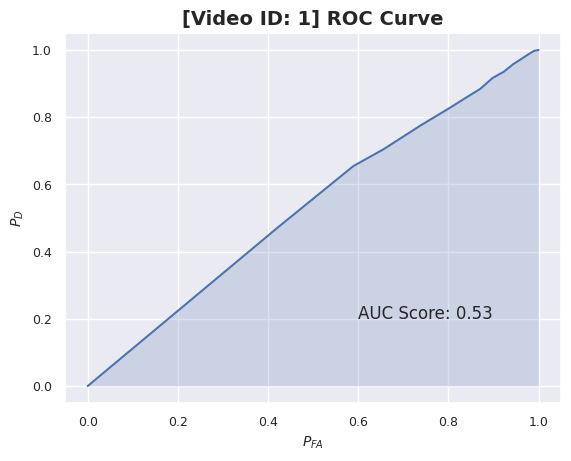

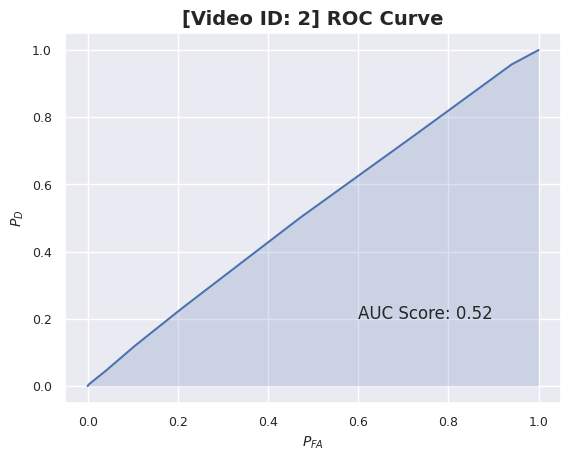

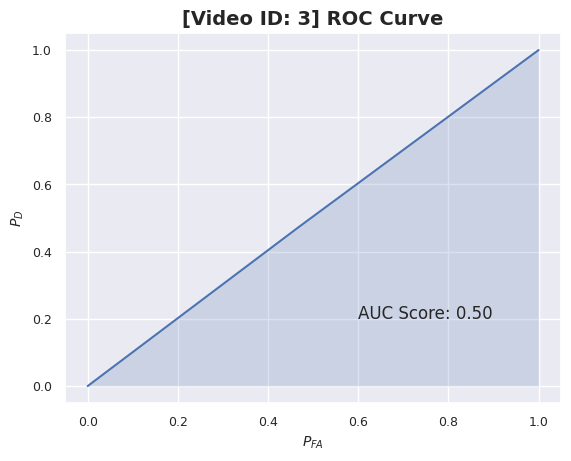

In [5]:
def make_classifier(threshold, mu0, std0, mu1, std1):
    """Returns a callable that classifies a given pixel as Positive event or Negative event."""

    def lrt_classifer(x) -> bool:
        """Simple likelihood ratio test based classifier. Returns `True` on positive event, `False` otherwise."""
        p_h0 = norm.pdf(x, mu0, std0)
        p_h1 = norm.pdf(x, mu1, std1)
        return p_h1 >= threshold * p_h0

    return lrt_classifer


N_DETECTIONS = 500

rng = np.random.default_rng()  # Random number generator

# Preparing dataset for classification
for videoID, ch_data in event_data.items():
    # Concatenate event data, first 20 frames correspond to positive event, the rest 20 negative event.
    # shape: (40 x height x width)
    r_data = np.concatenate((ch_data["R"]["max"], ch_data["R"]["min"]), axis=0)

    # Number of pixels in current video frame
    n_pixels = videoMeta[videoID]["FrameHeight"] * videoMeta[videoID]["FrameWidth"]
    # Flatten pixel values for each frame
    r_data = r_data.reshape(40, n_pixels)

    # Choose 500 pixels from each frame without replacement
    detection_data = np.apply_along_axis(
        lambda pixels: rng.choice(pixels, N_DETECTIONS, replace=False),
        axis=1,
        arr=r_data,
    )

    mu1, std1 = ch_data["R"]["stat_max"]  # H1: Positive event, Local maxima
    mu0, std0 = ch_data["R"]["stat_min"]  # H0: Negative event, Local minima

    # Holds data for ROC curve visualization
    roc_data = []
    for threshold in np.arange(0.1, 3, 0.05):
        # Generate classifer for a given threshold and likelihood distribution metrics
        classifier = make_classifier(threshold, mu0, std0, mu1, std1)

        # Predict events using the generated classifier
        predictions = np.apply_along_axis(classifier, axis=1, arr=detection_data)

        # Probablity of detection - Among the first 20 frames (positive event), count number of `True` values (positive event prediction)
        p_d = np.count_nonzero(predictions[:20, :]) / (predictions.size // 2)
        # Probablity of false alarm - Among the last 20 frames (negative event), count number of `True` values (positive event prediction)
        p_fa = np.count_nonzero(predictions[20:, :]) / (predictions.size // 2)

        roc_data.append([p_fa, p_d])

    # The area under the Receiver Operating Characteristic (ROC) curve , called the AUC score, gives a statistical measure on the quality
    # of the prediction model. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an
    # AUC of 1.0.
    roc_data = np.array(roc_data)
    p_fa = roc_data[:, 0]
    p_d = roc_data[:, 1]
    # Calculate area under curve using trapezoidal rule
    auc_score = abs(np.trapz(p_d, p_fa, dx=np.diff(p_fa).mean()))

    # Visualize ROC and AUC
    plt.plot(p_fa, p_d)
    plt.fill_between(p_fa, p_d, alpha=0.2)
    plt.text(0.6, 0.2, f"AUC Score: {auc_score:.2f}", fontsize=12)
    plt.xlabel("$P_{FA}$")
    plt.ylabel("$P_{D}$")
    plt.title(f"[Video ID: {videoID}] ROC Curve", fontsize=14, fontweight="bold")
    plt.show()


#### F. Are "good" samples spatially correlated? [20 marks]

First, choose an optimal threshold, $T_{OPT}$, that best suits your data (maximize $P_D$ while minimizing $P_{FA}$, you may look into maximizing the $\frac{P_D}{P_{FA}}$ ratio). Out of the 20000 total detections above for $T_{OPT}$, can it be hypothesised that the "good" samples (true positives and true negatives) are spatially clustered in certain areas of the frame, compared to the "bad" samples (false positives and false negatives)?


**Sol.** We observe that there is a huge clustering tendency in the samples, i.e the true positives and false negatives (in the case of a positive event) and true negatives and false positives (in the case of a negative event) are spatially clustered in certain areas of the frame. This may be because of the intensity variation within a frame due to flashlight location, i.e, pixels close the flashlight are brighter than the ones farther. We also observe that the average pixel intensity in a frame has larger SNR and captures the signal quite well, producing greatly separable distributions. Hence pixels values close this average intensity are more likely to be predicted/classified correctly and due to the intensity variation within a frame, these "more likely" pixels will be clustered together due to the non-uniform yet predictable intensity variation due to flashlight positioning.


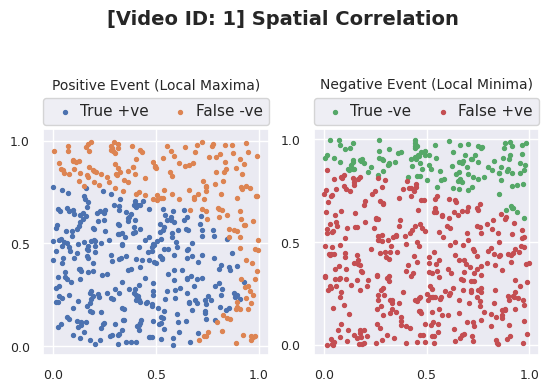

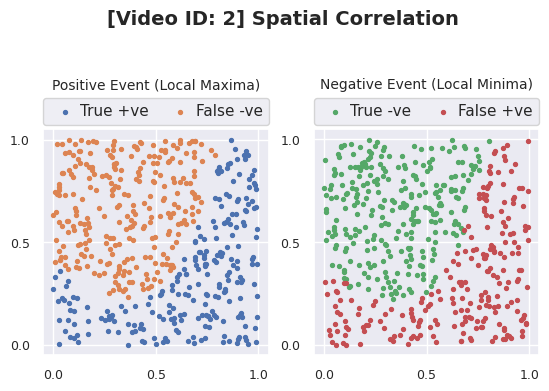

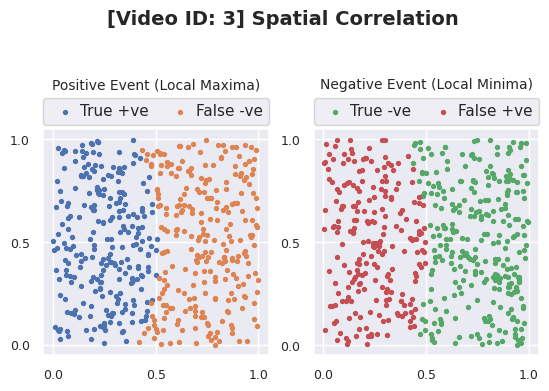

In [6]:
# Since the prediction models are basically worthless (no significant separation, models are no better than a random coin toss),
# we'll proceed with a threshold value of 1.0
T_OPT = 1.0

for videoID, ch_data in event_data.items():
    # Concatenate event data, first 20 frames correspond to positive event, the rest negative event.
    # shape: (40 x height x width)
    r_data = np.concatenate((ch_data["R"]["max"], ch_data["R"]["min"]), axis=0)

    # Number of pixels in current video frame
    n_pixels = videoMeta[videoID]["FrameHeight"] * videoMeta[videoID]["FrameWidth"]

    # Flatten pixel values for each frame
    r_data = r_data.reshape(40, n_pixels)

    # Choose 500 random pixel indices (flattened indices) for each frame. This will help
    # in visualization later
    detection_data_indices = np.apply_along_axis(
        lambda pxls: rng.choice(np.indices(pxls.shape).T, N_DETECTIONS, replace=False),
        axis=1,
        arr=r_data,
    ).squeeze()

    # Extract data corresponding to chosen indices
    detection_data = np.take_along_axis(r_data, detection_data_indices, axis=1)

    mu1, std1 = ch_data["R"]["stat_max"]  # H1: Positive event, Local maxima
    mu0, std0 = ch_data["R"]["stat_min"]  # H0: Negative event, Local minima

    # Build classifer for chosen threshold value and likelihood distribution metrics
    classifier = make_classifier(T_OPT, mu0, std0, mu1, std1)

    # Make predictions for data
    predictions = np.apply_along_axis(classifier, axis=1, arr=detection_data)

    # Choose a random frame among the first 20 frames (positive event)
    frame_id = np.random.randint(0, NHOOD_SIZE)
    # Extract indices corresponding to True positives and False negatives
    tp = detection_data_indices[frame_id, predictions[frame_id, :] == True]
    fn = detection_data_indices[frame_id, predictions[frame_id, :] == False]

    # Offset frame index to next 20 frames (negative event)
    frame_id += NHOOD_SIZE
    # Extract indices corresponding to True negatives and False positives
    tn = detection_data_indices[frame_id, predictions[frame_id, :] == False]
    fp = detection_data_indices[frame_id, predictions[frame_id, :] == True]

    f_h = videoMeta[videoID]["FrameHeight"]
    f_w = videoMeta[videoID]["FrameWidth"]

    # Auxiliary lambda to convert flattened indices to pixel coordinates and further normalize to [0, 1]
    # for visualization
    get_coords = lambda ind: [
        (ind % f_w).astype(np.float64) / f_w,
        (ind / f_w).astype(np.float64) / f_h,
    ]

    tp_x, tp_y = get_coords(tp)
    fn_x, fn_y = get_coords(fn)
    tn_x, tn_y = get_coords(tn)
    fp_x, fp_y = get_coords(fp)

    # Visualize spatial correlation of predictions
    plt.subplot(1, 2, 1)
    plt.scatter(tp_x, tp_y, s=8, color=cmap[0], label="True +ve")
    plt.scatter(fn_x, fn_y, s=8, color=cmap[1], label="False -ve")
    plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncols=2,
        handletextpad=0,
    )
    plt.axis("square")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    plt.title("Positive Event (Local Maxima)\n\n", fontsize="medium")

    plt.subplot(1, 2, 2)
    plt.scatter(tn_x, tn_y, s=8, color=cmap[2], label="True -ve")
    plt.scatter(fp_x, fp_y, s=8, color=cmap[3], label="False +ve")
    plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncols=2,
        handletextpad=0,
    )
    plt.axis("square")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    plt.title("Negative Event (Local Minima)\n\n", fontsize="medium")

    plt.suptitle(
        f"[Video ID: {videoID}] Spatial Correlation", fontsize=14, fontweight="bold"
    )
    plt.show()


#### Submission (report document: 10 marks)

##### Deadline: $4^{th}$, March, 2023

- Compress the top level directory (ZIP format) containing this notebook with filled-in code along with the ppgvideos folder.
- Include a PDF file (10 marks) within the directory, name it "report.pdf". Mention your name and roll number.
- The report should contain explanations related to the above assignments (A through F), assumptions if any, specific code explanations, algorithms used and inferences made from the plots. Also include references if any.
- <b>You MUST not consult your homework code with others</b>. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.
- Submissions after the deadline will not be entertained.
